In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
import sys
sys.path.append("./../code/")
from piCurve import *
from matplotlib import cm
from gwBackground import *
from makeDelayedRateData import *
from scipy.special import gammainc
from geometry import *
from math import comb,factorial
import population_parameters

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

In [2]:
def read_output(filepath):
    
    # Read hdf file
    hfile = h5py.File(filepath,'r')
    
    # Get joint 2D posteriors
    resultsDict = {k:v[()] for k,v in hfile['result'].items()}
    
    return resultsDict

def get_max_likelihood_params(resultDict):
    
    dc_argmax,z_argmax = np.unravel_index(np.argmax(resultDict['probabilities']),resultDict['probabilities'].shape)
    kappa_dc_max = resultDict['kappa_dcs_2D'][dc_argmax]
    kappa_z_max = resultDict['kappa_zs_2D'][z_argmax]
    
    return kappa_dc_max,kappa_z_max

In [3]:
# Input data
f_H1L1_O1,C_H1L1_O1,sigma_H1L1_O1 = np.loadtxt('../input/H1L1_O1.dat',unpack=True,skiprows=1)
f_H1L1_O2,C_H1L1_O2,sigma_H1L1_O2 = np.loadtxt('../input/H1L1_O2.dat',unpack=True,skiprows=1)
f_H1L1_O3,C_H1L1_O3,sigma_H1L1_O3 = np.loadtxt('../input/H1L1_O3.dat',unpack=True,skiprows=1)
f_H1V1_O3,C_H1V1_O3,sigma_H1V1_O3 = np.loadtxt('../input/H1V1_O3.dat',unpack=True,skiprows=1)
f_L1V1_O3,C_L1V1_O3,sigma_L1V1_O3 = np.loadtxt('../input/L1V1_O3.dat',unpack=True,skiprows=1)

# Inference results
HLO1 = read_output('./../data/fixed_rate_delayedSFR_HLO1.hdf')
HLO2 = read_output('./../data/fixed_rate_delayedSFR_HLO2.hdf')
HLO3 = read_output('./../data/fixed_rate_delayedSFR_HLO3.hdf')
HVO3 = read_output('./../data/fixed_rate_delayedSFR_HVO3.hdf')
LVO3 = read_output('./../data/fixed_rate_delayedSFR_LVO3.hdf')
full = read_output('./../data/fixed_rate_delayedSFR.hdf')

In [4]:
full_kappa_dc_max,full_kappa_z_max = get_max_likelihood_params(full)

In [5]:
# First prepare a grid of redshifts and (arbitrarily normalized) merger rate values.
# In this case, our model a metallicity-weighted and time-delayed Madau+Dickinson SFR
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
time_delays = rateData['tds']
zs_formation = rateData['formationRedshifts']
formationRates = rateData['formationRates']

# The following function is an approximation to the integrated fraction of star formation below
# Z=Z_sun/10 as a function of redshift
low_Z_fraction = gammainc(0.84,(0.1**2.)*np.power(10.,0.3*zs_formation))

# Multiply by total formation rate to get the rate of low metallicity star formation
weightedFormationRates = formationRates*low_Z_fraction

# Convolve formation rate with time-delay distribution
# Set t_min = 10 Myr
tdMin = 0.01
dpdt = np.power(time_delays,-1)
dpdt[time_delays<tdMin] = 0.
dRdV_delayed = weightedFormationRates.dot(dpdt)
dRdV_delayed /= dRdV_delayed[0]

# Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

# Define hyperparameters describing mass distribution
R0 = population_parameters.R0
m_min = population_parameters.m_min
m_max = population_parameters.m_max
dm_min = population_parameters.dm_min
dm_max = population_parameters.dm_max
alpha = population_parameters.alpha_m
mu_peak = population_parameters.mu_peak
sig_peak = population_parameters.sig_peak
frac_peak = population_parameters.frac_peak
bq = population_parameters.bq

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,dm_min,dm_max,alpha,mu_peak,sig_peak,frac_peak,bq)

/Users/tcallister/Documents/Repositories/stochastic-birefringence/figures/./../code/gwBackground.py:352: RuntimeWarning: divide by zero encountered in divide
  probs_m2 = (1.+bq)*np.power(self.m2s_2d,bq)/(np.power(self.m1s_2d,1.+bq)-2.**(1.+bq))


In [6]:
# As noted elsewhere, to properly define the cumulative SNR we have to use identical ORFs
# to those used in the initial creation of the stochastic data.
# Hence we are loading in ORFs computed using stochastic.m
matlab_orf_freqs,matlab_orf_H1L1,matlab_orf_H1V1,matlab_orf_L1V1 = np.loadtxt('../input/matlab_orfs.dat',unpack=True)

# Also as noted elsewhere, the frequency arrays in publicly released stochastic data lack the
# required precision to fully specify the correct frequencies. Load frequencies as well
# from the raw matlab calculation
freqs = matlab_orf_freqs[matlab_orf_freqs<=1726]
matlab_orf_H1L1 = matlab_orf_H1L1[matlab_orf_freqs<=1726]
matlab_orf_H1V1 = matlab_orf_H1V1[matlab_orf_freqs<=1726]
matlab_orf_L1V1 = matlab_orf_L1V1[matlab_orf_freqs<=1726]

# Instantiate baseline objects
H1L1 = Baseline(Detector.H1(),Detector.L1())
H1V1 = Baseline(Detector.H1(),Detector.V1())
L1V1 = Baseline(Detector.L1(),Detector.V1())

# Use baseline objects to compute overlap reduction functions for Stokes-I and Stokes-V signals
H1L1_gammaI,H1L1_gammaV = H1L1.stokes_overlap_reduction_functions(freqs)
H1V1_gammaI,H1V1_gammaV = H1V1.stokes_overlap_reduction_functions(freqs)
L1V1_gammaI,L1V1_gammaV = L1V1.stokes_overlap_reduction_functions(freqs)

In [7]:
# Evaluate background
full_OmgI,full_OmgV = omg.eval(R0,dRdV_delayed,freqs,full_kappa_dc_max,full_kappa_z_max)

# Obtain signal models for each baseline
HL_model = np.array(full_OmgI + (H1L1_gammaV/matlab_orf_H1L1)*full_OmgV)
HV_model = np.array(full_OmgI + (H1V1_gammaV/matlab_orf_H1V1)*full_OmgV)
LV_model = np.array(full_OmgI + (L1V1_gammaV/matlab_orf_L1V1)*full_OmgV)

In [8]:
def get_total_snr(Cs,sigmas,model):
    
    Cs[np.isinf(sigmas)] = 0
    signal_inner_model = np.sum(Cs*model/sigmas**2)
    model_inner_model = np.sum(model**2/sigmas**2)
    
    return signal_inner_model/np.sqrt(model_inner_model)

In [9]:
# Hanford-Livingston SNRs
actual_HL_O1 = get_total_snr(C_H1L1_O1,sigma_H1L1_O1,HL_model)
actual_HL_O2 = get_total_snr(C_H1L1_O2,sigma_H1L1_O2,HL_model)
actual_HL = get_total_snr(C_H1L1_O3,sigma_H1L1_O3,HL_model)
optimal_HL_O1 = get_total_snr(HL_model,sigma_H1L1_O1,HL_model)
optimal_HL_O2 = get_total_snr(HL_model,sigma_H1L1_O2,HL_model)
optimal_HL = get_total_snr(HL_model,sigma_H1L1_O3,HL_model)

# Hanford-Virgo SNRs
actual_HV = get_total_snr(C_H1V1_O3,sigma_H1V1_O3,HV_model)
optimal_HV = get_total_snr(HV_model,sigma_H1V1_O3,HV_model)

# Livingston-Virgo SNRs
actual_LV = get_total_snr(C_L1V1_O3,sigma_L1V1_O3,LV_model)
optimal_LV = get_total_snr(LV_model,sigma_L1V1_O3,LV_model)

In [10]:
nTrials = 100000

# Draw random Gaussian distributed "observed" SNRs about predicted expectation value
snrs_HL_O1 = np.random.normal(loc=optimal_HL_O1,scale=1,size=nTrials)
snrs_HL_O2 = np.random.normal(loc=optimal_HL_O2,scale=1,size=nTrials)
snrs_HL = np.random.normal(loc=optimal_HL,scale=1,size=nTrials)
snrs_HV = np.random.normal(loc=optimal_HV,scale=1,size=nTrials)
snrs_LV = np.random.normal(loc=optimal_LV,scale=1,size=nTrials)

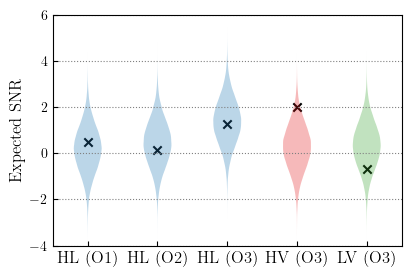

In [11]:
fig,ax = plt.subplots(figsize=(4.5,3))

ax.scatter([1,2,3,4,5],
           [actual_HL_O1,actual_HL_O2,actual_HL,actual_HV,actual_LV],
           marker='x',color='black')

violins = ax.violinplot([snrs_HL_O1,snrs_HL_O2,snrs_HL,snrs_HV,snrs_LV],showextrema=False,widths=0.4)
violins['bodies'][0].set_facecolor(blue)
violins['bodies'][1].set_facecolor(blue)
violins['bodies'][2].set_facecolor(blue)
violins['bodies'][3].set_facecolor(red)
violins['bodies'][4].set_facecolor(green)

ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels([r'HL~(O1)',r'HL~(O2)',r'HL~(O3)',r'HV~(O3)',r'LV~(O3)'],fontsize=12)

ax.set_xlim(0.5,5.5)
ax.set_ylabel('Expected SNR')
ax.xaxis.grid(False)
ax.set_ylim(-4,6)

plt.savefig('figure_13.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [12]:
def cumulative_prob(observed,expected):
    return 0.5*(1.+erf((observed-expected)/np.sqrt(2.)))

In [13]:
p_HV_geq_observed = 1 - cumulative_prob(actual_HV,optimal_HV)
p_LV_leq_observed = cumulative_prob(actual_LV,optimal_LV)
p_HV_geq_observed*p_LV_leq_observed

0.006507720207626562

In [14]:
above_HV = 1 - cumulative_prob(actual_HV,optimal_HV)
below_HV = cumulative_prob(actual_HV,optimal_HV)

p_above = comb(5,5)*above_HV**5 \
            + comb(5,4)*above_HV**4*below_HV \
            + comb(5,3)*above_HV**3*below_HV**2 \
            + comb(5,2)*above_HV**2*below_HV**3 \
            + comb(5,1)*above_HV*below_HV**4

print(p_above)

0.2013050946026458


In [15]:
above_HV = 1 - cumulative_prob(actual_HV,optimal_HV)
below_LV = cumulative_prob(actual_LV,optimal_LV)

def m_choose_ab(m,a,b):
    return factorial(m)/(factorial(a)*factorial(b)*factorial(m-a-b))

p_above_and_below = m_choose_ab(5,1,1)*above_HV*below_LV*(1.-above_HV-below_LV)**3 \
                        + m_choose_ab(5,1,2)*above_HV*below_LV**2*(1.-above_HV-below_LV)**2 \
                        + m_choose_ab(5,1,3)*above_HV*below_LV**3*(1.-above_HV-below_LV) \
                        + m_choose_ab(5,1,4)*above_HV*below_LV**4 \
                        + m_choose_ab(5,2,1)*above_HV**2*below_LV*(1.-above_HV-below_LV)**2 \
                        + m_choose_ab(5,2,2)*above_HV**2*below_LV**2*(1.-above_HV-below_LV) \
                        + m_choose_ab(5,2,3)*above_HV**2*below_LV**3 \
                        + m_choose_ab(5,3,1)*above_HV**3*below_LV*(1.-above_HV-below_LV) \
                        + m_choose_ab(5,3,2)*above_HV**3*below_LV**2 \
                        + m_choose_ab(5,4,1)*above_HV**4*below_LV

print(p_above_and_below)

0.09685510227916795


In [16]:
above_HV = 1 - cumulative_prob(actual_HV,0)
below_HV = cumulative_prob(actual_HV,0)

p_above_pureNoise = comb(5,5)*above_HV**5 \
            + comb(5,4)*above_HV**4*below_HV \
            + comb(5,3)*above_HV**3*below_HV**2 \
            + comb(5,2)*above_HV**2*below_HV**3 \
            + comb(5,1)*above_HV*below_HV**4

print(p_above_pureNoise)

0.11100199881407995


In [17]:
above_HV = 1 - cumulative_prob(actual_HV,0)
below_LV = cumulative_prob(actual_LV,0)

def m_choose_ab(m,a,b):
    return factorial(m)/(factorial(a)*factorial(b)*factorial(m-a-b))

p_above_and_below_pureNoise = m_choose_ab(5,1,1)*above_HV*below_LV*(1.-above_HV-below_LV)**3 \
                        + m_choose_ab(5,1,2)*above_HV*below_LV**2*(1.-above_HV-below_LV)**2 \
                        + m_choose_ab(5,1,3)*above_HV*below_LV**3*(1.-above_HV-below_LV) \
                        + m_choose_ab(5,1,4)*above_HV*below_LV**4 \
                        + m_choose_ab(5,2,1)*above_HV**2*below_LV*(1.-above_HV-below_LV)**2 \
                        + m_choose_ab(5,2,2)*above_HV**2*below_LV**2*(1.-above_HV-below_LV) \
                        + m_choose_ab(5,2,3)*above_HV**2*below_LV**3 \
                        + m_choose_ab(5,3,1)*above_HV**3*below_LV*(1.-above_HV-below_LV) \
                        + m_choose_ab(5,3,2)*above_HV**3*below_LV**2 \
                        + m_choose_ab(5,4,1)*above_HV**4*below_LV

print(p_above_and_below_pureNoise)

0.07471216628504074


In [18]:
# Save our fitting results
with open('./SNR_probabilities.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\ProbHVSNR}}{{{0:.3f}}}".format(p_HV_geq_observed))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ProbLVSNR}}{{{0:.2f}}}".format(p_LV_leq_observed))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ProbHVLVSNR}}{{{0:.4f}}}".format(p_HV_geq_observed*p_LV_leq_observed))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ProbAboveWithTrials}}{{{0:.2f}}}".format(p_above))
    macrofile.write("\n")

    macrofile.write("\\newcommand{{\\ProbAboveAndBelowWithTrials}}{{{0:.2f}}}".format(p_above_and_below))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ProbAboveWithTrialsNoise}}{{{0:.2f}}}".format(p_above_pureNoise))
    macrofile.write("\n")

    macrofile.write("\\newcommand{{\\ProbAboveAndBelowWithTrialsNoise}}{{{0:.2f}}}".format(p_above_and_below_pureNoise))
    macrofile.write("\n")